In [1]:
# Monter  le dossier des données de la tache 2 dans l'espace de travail

# https://drive.google.com/drive/folders/1EqCi3S9JmOj33QPewUbvYPsujWWgJE1d?usp=sharing

# Tâche 2 : Estimation de l'Âge à partir d'une Photo

Ce notebook a pour objectif de résoudre la deuxième tâche du challenge ANIP : prédire l'âge d'une personne à partir d'une image faciale.

## Objectif

Développer une IA capable de prédire l'âge d'une personne à partir d'une image avec la meilleure précision possible.

## Stratégie adoptée

Notre approche sera méthodique et basée sur les meilleures pratiques :

1. **Analyse Exploratoire des Données (AED)** : Comprendre la distribution des âges, sexes, et qualité des images
2. **Préparation des données** : Parsing des noms de fichiers, normalisation, augmentation
3. **Modélisation avec Transfer Learning** : Utilisation de modèles pré-entraînés optimisés pour la régression d'âge
4. **Évaluation et optimisation** : Métriques MAE/RMSE, validation croisée, tuning
5. **Prédiction finale** : Application sur les 200 images de test et génération de la soumission

In [2]:
# Importation des bibliothèques fondamentales
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
print("Bibliothèques de base importées.")

Bibliothèques de base importées.


## 1. Configuration de l'Environnement

Définition des chemins et vérification de l'accès aux données de la tâche 2.

In [3]:
# Configuration des chemins de données
from pathlib import Path
import os

# Configuration pour Kaggle
# Quand tu uploaderas les données sur Kaggle, elles seront disponibles ici :
DATA_ROOT = Path("/kaggle/input/anip-challenge2-tache2/dataset_tache_2")  #  Nom du dataset sur Kaggle
TRAIN_DIR = DATA_ROOT / 'dataset_tache_2/train'
TEST_DIR = DATA_ROOT / 'dataset_tache_2/test'
# SUBMISSIONS_DIR = Path('/kaggle/working')

print("Configuration Kaggle:")
print(f"Dataset root: {DATA_ROOT}")
print(f"Train directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")
# print(f Submissions: {SUBMISSIONS_DIR}")

# Vérification des chemins
train_exists = TRAIN_DIR.exists()
test_exists = TEST_DIR.exists()

print(f"\n Vérification:")
print(f"   Train folder: {'okay' if train_exists else 'Non'} {TRAIN_DIR}")
print(f"   Test folder: {'yes' if test_exists else 'No'} {TEST_DIR}")

if train_exists:
    # Recherche des images avec extensions robustes
    train_files = []
    for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
        train_files.extend(list(TRAIN_DIR.glob(ext)))

    print(f"Images d'entraînement: {len(train_files)}")

    if len(train_files) > 0:
        print(f"Exemples de fichiers:")
        for file in train_files[:3]:
            print(f"      - {file.name}")
else:
    print("   Les données ne sont pas encore uploadées sur Kaggle")
    print("  Après upload, ce code fonctionnera automatiquement!")
    # Variables vides pour éviter les erreurs
    train_files = []

if test_exists:
    test_files = []
    for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
        test_files.extend(list(TEST_DIR.glob(ext)))
    print(f"Images de test: {len(test_files)}")
else:
    test_files = []

Configuration Kaggle:
Dataset root: /kaggle/input/anip-challenge2-tache2/dataset_tache_2
Train directory: /kaggle/input/anip-challenge2-tache2/dataset_tache_2/dataset_tache_2/train
Test directory: /kaggle/input/anip-challenge2-tache2/dataset_tache_2/dataset_tache_2/test

 Vérification:
   Train folder: okay /kaggle/input/anip-challenge2-tache2/dataset_tache_2/dataset_tache_2/train
   Test folder: yes /kaggle/input/anip-challenge2-tache2/dataset_tache_2/dataset_tache_2/test
Images d'entraînement: 40012
Exemples de fichiers:
      - 093092_4M35.JPG
      - 292881_04M20.JPG
      - 293889_01M30.JPG
Images de test: 200


## 2. Analyse Exploratoire des Données (AED)

### 2.1 Parsing des noms de fichiers

Les fichiers d'entraînement suivent le format : `XXXXXX_YZWW` où :
- `XXXXXX` : identifiant de la personne
- `Y` : numéro de la photo pour une même personne (à partir de 0)
- `Z` : sexe (M ou F)
- `WW` : âge de la personne

In [4]:
def parse_filename(filename):
    """
    Parse le nom de fichier pour extraire les informations.
    Format: ID_NUMERO[M|F]AGE.jpg où :
    - ID : identifiant de la personne (nombre variable de chiffres)
    - NUMERO : numéro de la photo pour une même personne (nombre variable de chiffres)
    - [M|F] : sexe (M ou F)
    - AGE : âge de la personne (2 chiffres)
    """
    # Enlever l'extension
    name = filename.stem if hasattr(filename, 'stem') else Path(filename).stem

    # Pattern regex plus flexible basé sur l'underscore et la lettre M/F
    # Chercher: (chiffres)_(chiffres)[M|F](2 chiffres)
    pattern = r'(\d+)_(\d+)([MF])(\d{2})'
    match = re.match(pattern, name)

    if match:
        person_id = match.group(1)
        photo_num = int(match.group(2))
        gender = match.group(3)
        age = int(match.group(4))

        return {
            'filename': name + Path(str(filename)).suffix,  # Garder la vraie extension
            'person_id': person_id,
            'photo_num': photo_num,
            'gender': gender,
            'age': age
        }
    else:
        # Debug pour voir ce qui ne marche pas
        print(f"⚠️ Impossible de parser: '{name}' (pattern attendu: ID_NUMERO[M|F]AGE)")
        return None

# Test de la fonction de parsing avec les fichiers trouvés
if 'train_files' in locals() and train_files:
    sample_files = train_files[:10]  # Tester plus de fichiers
    print("Test de parsing sur quelques fichiers :")
    success_count = 0
    for file in sample_files:
        parsed = parse_filename(file)
        if parsed:
            print(f"  ✅ {file.name} -> Personne: {parsed['person_id']}, Photo: {parsed['photo_num']}, Sexe: {parsed['gender']}, Âge: {parsed['age']}")
            success_count += 1
        else:
            print(f"  ❌ {file.name} -> Échec du parsing")
    print(f"\nTaux de réussite: {success_count}/{len(sample_files)} ({success_count/len(sample_files)*100:.1f}%)")
else:
    print("❌ Aucun fichier d'entraînement trouvé pour tester le parsing.")

# Si pas d'images mais qu'il y a des fichiers, montrer quelques exemples
if 'train_files' in locals() and len(train_files) == 0 and TRAIN_DIR.exists():
    all_files = list(TRAIN_DIR.iterdir())[:5]
    if all_files:
        print("\n🔍 Exemples de fichiers dans le dossier (pour debug):")
        for file in all_files:
            print(f"  {file.name}")
            # Essayer de parser quand même
            try:
                parsed = parse_filename(file)
                if parsed:
                    print(f"    ✅ Parsing réussi!")
            except:
                pass

# Analyse des patterns de noms pour debug
if 'train_files' in locals() and train_files:
    print(f"\nAnalyse des patterns de noms (premiers 10 fichiers):")
    for i, file in enumerate(train_files[:10]):
        name = file.stem
        print(f"{i+1}. '{name}' (longueur: {len(name)})")

        # Vérifier le pattern de base
        if '_' in name:
            parts = name.split('_')
            if len(parts) == 2:
                print(f" ID: '{parts[0]}' (longueur: {len(parts[0])})")
                print(f" Suffix: '{parts[1]}' (longueur: {len(parts[1])})")

                # Analyser le suffix pour identifier M/F
                suffix = parts[1]
                for j, char in enumerate(suffix):
                    if char in ['M', 'F']:
                        photo_part = suffix[:j]
                        age_part = suffix[j+1:]
                        print(f"        -> Photo: '{photo_part}', Sexe: '{char}', Âge: '{age_part}'")
                        break
            else:
                print(f" Nombre de parties après split '_': {len(parts)}")
        else:
            print(f" Pas de '_' trouvé dans le nom")

Test de parsing sur quelques fichiers :
  ✅ 093092_4M35.JPG -> Personne: 093092, Photo: 4, Sexe: M, Âge: 35
  ✅ 292881_04M20.JPG -> Personne: 292881, Photo: 4, Sexe: M, Âge: 20
  ✅ 293889_01M30.JPG -> Personne: 293889, Photo: 1, Sexe: M, Âge: 30
  ✅ 288914_01M27.JPG -> Personne: 288914, Photo: 1, Sexe: M, Âge: 27
  ✅ 118481_0F31.JPG -> Personne: 118481, Photo: 0, Sexe: F, Âge: 31
  ✅ 099377_0M33.JPG -> Personne: 099377, Photo: 0, Sexe: M, Âge: 33
  ✅ 105458_4F35.JPG -> Personne: 105458, Photo: 4, Sexe: F, Âge: 35
  ✅ 229328_00M29.JPG -> Personne: 229328, Photo: 0, Sexe: M, Âge: 29
  ✅ 240474_05M25.JPG -> Personne: 240474, Photo: 5, Sexe: M, Âge: 25
  ✅ 337161_00M19.JPG -> Personne: 337161, Photo: 0, Sexe: M, Âge: 19

Taux de réussite: 10/10 (100.0%)

Analyse des patterns de noms (premiers 10 fichiers):
1. '093092_4M35' (longueur: 11)
 ID: '093092' (longueur: 6)
 Suffix: '4M35' (longueur: 4)
        -> Photo: '4', Sexe: 'M', Âge: '35'
2. '292881_04M20' (longueur: 12)
 ID: '292881' (long

In [5]:
# Parsing des métadonnées depuis les noms de fichiers
print("🔍 PARSING DES MÉTADONNÉES DEPUIS LES NOMS DE FICHIERS")
print("="*60)

# Vérifier que nous avons des fichiers à traiter
if len(train_files) == 0:
    print("Aucun fichier d'entraînement trouvé!")
    print("Assurez-voys d'avoir uploadé le dataset 'anip-dataset-tache-2' sur Kaggle")
    df_train = pd.DataFrame()  # DataFrame vide pour éviter les erreurs
else:
    data_list = []
    parsing_errors = 0

    for file_path in train_files:
        parsed = parse_filename(file_path)
        if parsed:
            parsed['file_path'] = str(file_path)
            data_list.append(parsed)
        else:
            parsing_errors += 1

    # Créer le DataFrame principal
    df_train = pd.DataFrame(data_list)

    print(f"✅ Parsing terminé !")
    print(f"   Fichiers parsés avec succès: {len(df_train)}")
    print(f"   Erreurs de parsing: {parsing_errors}")
    print(f"   Total fichiers traités: {len(train_files)}")

    if len(df_train) > 0:
        print("\nAperçu des données:")
        print(df_train.head(10))

        print("\nInformations sur le dataset:")
        print(df_train.info())

🔍 PARSING DES MÉTADONNÉES DEPUIS LES NOMS DE FICHIERS
✅ Parsing terminé !
   Fichiers parsés avec succès: 40012
   Erreurs de parsing: 0
   Total fichiers traités: 40012

Aperçu des données:
           filename person_id  photo_num gender  age  \
0   093092_4M35.JPG    093092          4      M   35   
1  292881_04M20.JPG    292881          4      M   20   
2  293889_01M30.JPG    293889          1      M   30   
3  288914_01M27.JPG    288914          1      M   27   
4   118481_0F31.JPG    118481          0      F   31   
5   099377_0M33.JPG    099377          0      M   33   
6   105458_4F35.JPG    105458          4      F   35   
7  229328_00M29.JPG    229328          0      M   29   
8  240474_05M25.JPG    240474          5      M   25   
9  337161_00M19.JPG    337161          0      M   19   

                                           file_path  
0  /kaggle/input/anip-challenge2-tache2/dataset_t...  
1  /kaggle/input/anip-challenge2-tache2/dataset_t...  
2  /kaggle/input/anip-chall

### 2.2 Analyse de la distribution des âges

ANALYSE DE LA DISTRIBUTION DES ÂGES
Statistiques descriptives:
count    40012.000000
mean        32.869589
std         10.923139
min         16.000000
25%         23.000000
50%         33.000000
75%         41.000000
max         77.000000
Name: age, dtype: float64

Âge minimum: 16 ans
Âge maximum: 77 ans
Âge médian: 33.0 ans
Âge moyen: 32.9 ans


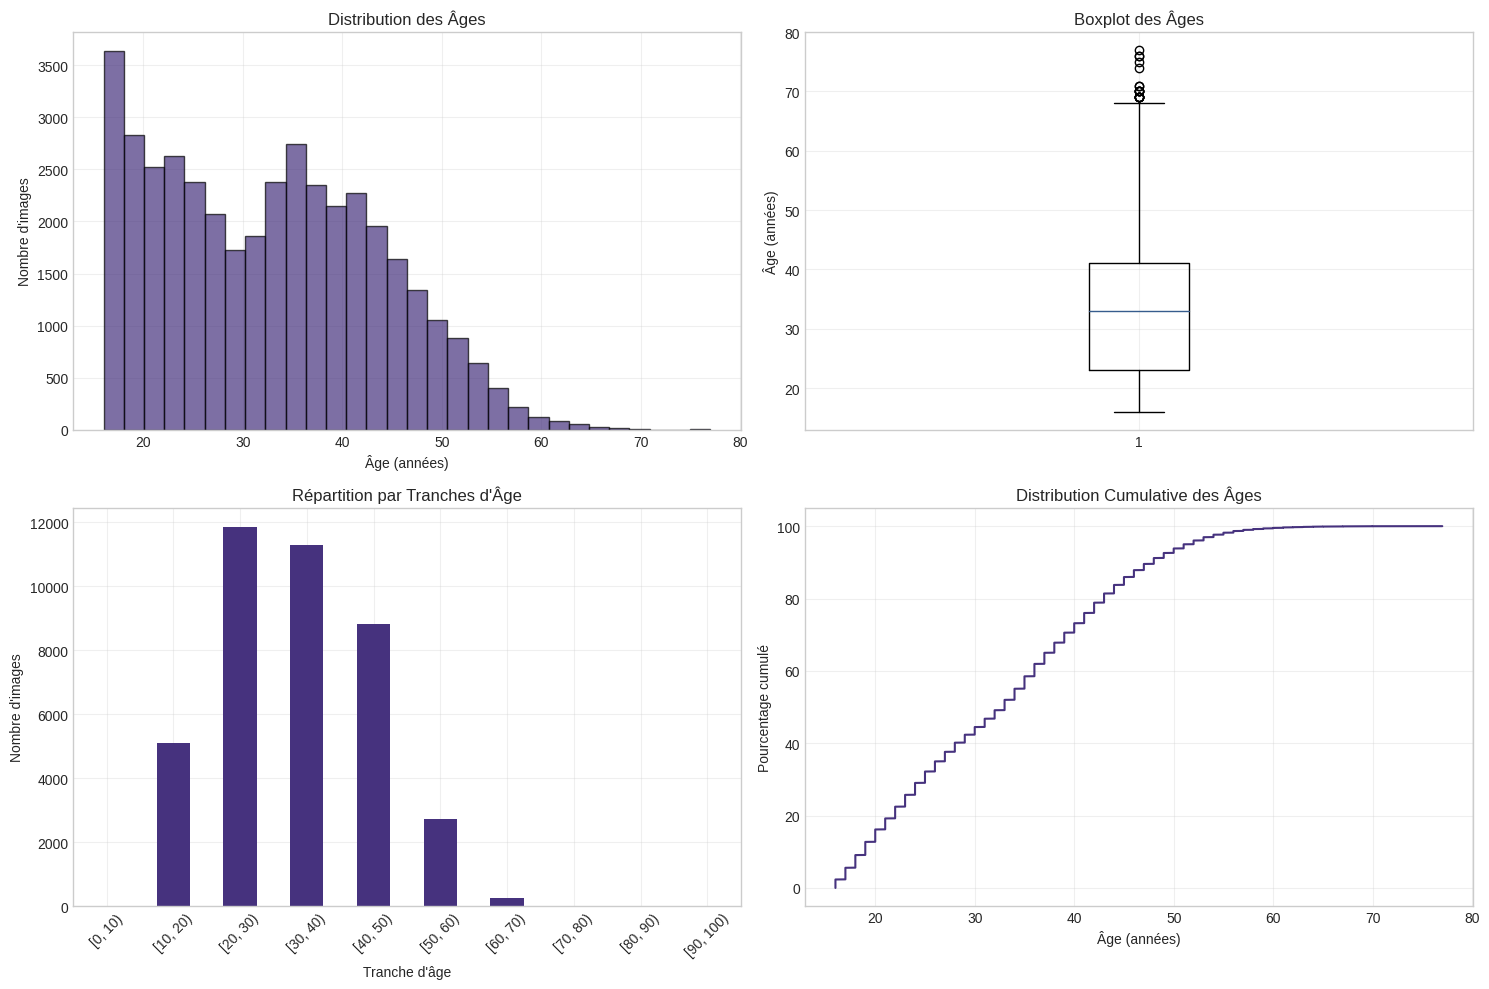


📊 Analyse détaillée:
   25ème percentile: 23.0 ans
   75ème percentile: 41.0 ans
   Écart interquartile: 18.0 ans


In [6]:
if len(df_train) > 0:
    # Statistiques descriptives des âges
    print("ANALYSE DE LA DISTRIBUTION DES ÂGES")
    print("="*50)

    print("Statistiques descriptives:")
    age_stats = df_train['age'].describe()
    print(age_stats)

    print(f"\nÂge minimum: {df_train['age'].min()} ans")
    print(f"Âge maximum: {df_train['age'].max()} ans")
    print(f"Âge médian: {df_train['age'].median()} ans")
    print(f"Âge moyen: {df_train['age'].mean():.1f} ans")

    # Visualisation de la distribution
    plt.figure(figsize=(15, 10))

    # Histogramme principal
    plt.subplot(2, 2, 1)
    plt.hist(df_train['age'], bins=30, alpha=0.7, edgecolor='black')
    plt.title('Distribution des Âges')
    plt.xlabel('Âge (années)')
    plt.ylabel('Nombre d\'images')
    plt.grid(True, alpha=0.3)

    # Boxplot
    plt.subplot(2, 2, 2)
    plt.boxplot(df_train['age'])
    plt.title('Boxplot des Âges')
    plt.ylabel('Âge (années)')
    plt.grid(True, alpha=0.3)

    # Distribution par tranches d'âge
    plt.subplot(2, 2, 3)
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_groups_temp = pd.cut(df_train['age'], bins=age_bins, right=False)
    age_group_counts = age_groups_temp.value_counts().sort_index()
    age_group_counts.plot(kind='bar', rot=45)
    plt.title('Répartition par Tranches d\'Âge')
    plt.xlabel('Tranche d\'âge')
    plt.ylabel('Nombre d\'images')
    plt.grid(True, alpha=0.3)

    # Distribution cumulative
    plt.subplot(2, 2, 4)
    sorted_ages = df_train['age'].sort_values()
    cumulative_percent = np.arange(1, len(sorted_ages) + 1) / len(sorted_ages) * 100
    plt.plot(sorted_ages, cumulative_percent)
    plt.title('Distribution Cumulative des Âges')
    plt.xlabel('Âge (années)')
    plt.ylabel('Pourcentage cumulé')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Analyse plus détaillée
    print(f"\n📊 Analyse détaillée:")
    print(f"   25ème percentile: {df_train['age'].quantile(0.25):.1f} ans")
    print(f"   75ème percentile: {df_train['age'].quantile(0.75):.1f} ans")
    print(f"   Écart interquartile: {df_train['age'].quantile(0.75) - df_train['age'].quantile(0.25):.1f} ans")

else:
    print("⚠️  Pas de données à analyser - dataset non disponible")

### 2.3 Analyse des personnes et photos multiples

ANALYSE DE LA DISTRIBUTION PAR SEXE
Répartition par sexe:
   Hommes: 34,433 images (86.1%)
   Femmes: 5,579 images (13.9%)


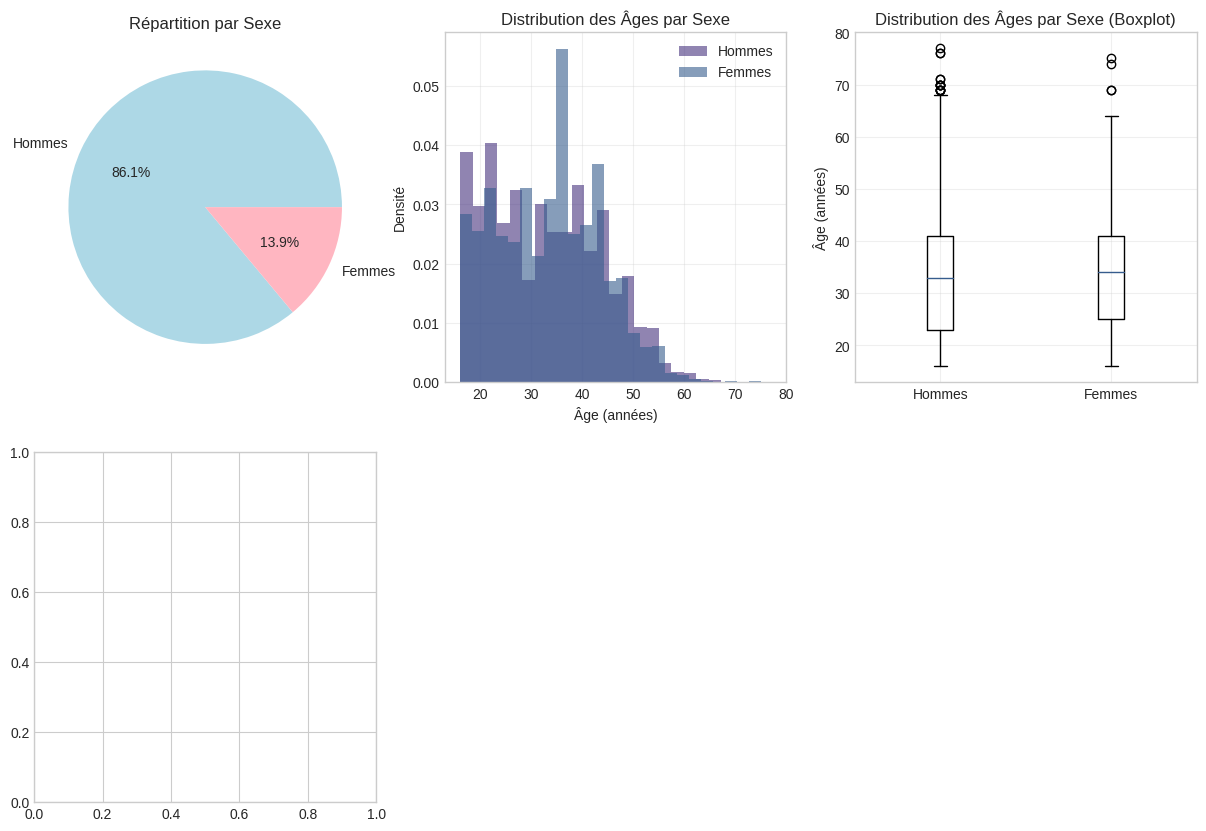

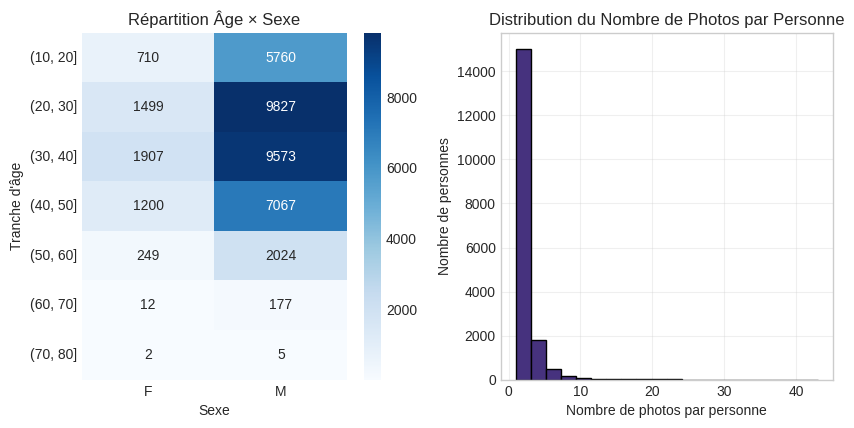


Statistiques par sexe:

Hommes:
   Âge moyen: 32.8 ans
   Âge médian: 33.0 ans
   Écart-type: 11.1 ans
   Min-Max: 16-77 ans

Femmes:
   Âge moyen: 33.4 ans
   Âge médian: 34.0 ans
   Écart-type: 10.0 ans
   Min-Max: 16-75 ans

 Photos par personne:
   Moyenne: 2.3 photos/personne
   Médiane: 2.0 photos/personne
   Min-Max: 1-43 photos/personne


In [7]:
if len(df_train) > 0:
    # Analyse de la distribution par sexe
    print("ANALYSE DE LA DISTRIBUTION PAR SEXE")
    print("="*40)

    gender_counts = df_train['gender'].value_counts()
    gender_percentages = df_train['gender'].value_counts(normalize=True) * 100

    print("Répartition par sexe:")
    for gender in ['M', 'F']:
        if gender in gender_counts:
            count = gender_counts[gender]
            percentage = gender_percentages[gender]
            gender_name = 'Hommes' if gender == 'M' else 'Femmes'
            print(f"   {gender_name}: {count:,} images ({percentage:.1f}%)")

    # Visualisation
    plt.figure(figsize=(15, 10))

    # Pie chart de la répartition
    plt.subplot(2, 3, 1)
    labels = ['Hommes' if g == 'M' else 'Femmes' for g in gender_counts.index]
    colors = ['lightblue', 'lightpink']
    plt.pie(gender_counts.values, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.title('Répartition par Sexe')

    # Distribution des âges par sexe
    plt.subplot(2, 3, 2)
    for gender in ['M', 'F']:
        if gender in df_train['gender'].values:
            ages = df_train[df_train['gender'] == gender]['age']
            label = 'Hommes' if gender == 'M' else 'Femmes'
            plt.hist(ages, bins=25, alpha=0.6, label=label, density=True)
    plt.xlabel('Âge (années)')
    plt.ylabel('Densité')
    plt.title('Distribution des Âges par Sexe')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Box plot des âges par sexe
    plt.subplot(2, 3, 3)
    gender_data = [df_train[df_train['gender'] == 'M']['age'].values,
                   df_train[df_train['gender'] == 'F']['age'].values]
    plt.boxplot(gender_data, labels=['Hommes', 'Femmes'])
    plt.ylabel('Âge (années)')
    plt.title('Distribution des Âges par Sexe (Boxplot)')
    plt.grid(True, alpha=0.3)

    # Statistiques par sexe
    plt.subplot(2, 3, 4)
    stats_by_gender = df_train.groupby('gender')['age'].agg(['mean', 'median', 'std']).round(1)
    stats_by_gender.plot(kind='bar', rot=0)
    plt.title('Statistiques des Âges par Sexe')
    plt.ylabel('Âge (années)')
    plt.xlabel('Sexe')
    plt.legend(['Moyenne', 'Médiane', 'Écart-type'])
    plt.grid(True, alpha=0.3)

    # Heatmap âge vs sexe
    plt.subplot(2, 3, 5)
    age_bins = range(0, 101, 10)
    df_train['age_bin'] = pd.cut(df_train['age'], bins=age_bins)
    heatmap_data = pd.crosstab(df_train['age_bin'], df_train['gender'])
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
    plt.title('Répartition Âge × Sexe')
    plt.ylabel('Tranche d\'âge')
    plt.xlabel('Sexe')

    # Distribution du nombre de photos par personne
    plt.subplot(2, 3, 6)
    photos_per_person = df_train['person_id'].value_counts()
    plt.hist(photos_per_person, bins=20, edgecolor='black')
    plt.xlabel('Nombre de photos par personne')
    plt.ylabel('Nombre de personnes')
    plt.title('Distribution du Nombre de Photos par Personne')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistiques détaillées
    print(f"\nStatistiques par sexe:")
    for gender in ['M', 'F']:
        if gender in df_train['gender'].values:
            subset = df_train[df_train['gender'] == gender]
            gender_name = 'Hommes' if gender == 'M' else 'Femmes'
            print(f"\n{gender_name}:")
            print(f"   Âge moyen: {subset['age'].mean():.1f} ans")
            print(f"   Âge médian: {subset['age'].median():.1f} ans")
            print(f"   Écart-type: {subset['age'].std():.1f} ans")
            print(f"   Min-Max: {subset['age'].min()}-{subset['age'].max()} ans")

    print(f"\n Photos par personne:")
    print(f"   Moyenne: {photos_per_person.mean():.1f} photos/personne")
    print(f"   Médiane: {photos_per_person.median():.1f} photos/personne")
    print(f"   Min-Max: {photos_per_person.min()}-{photos_per_person.max()} photos/personne")

else:
    print("Pas de données à analyser - dataset non disponible")

### 2.4 Visualisation d'exemples d'images par âge et sexe

🔍 ANALYSE AVANCÉE DES PATTERNS
Statistiques générales:
   Personnes uniques: 17,588
   Total d'images: 40,012
   Photos par personne (moyenne): 2.3


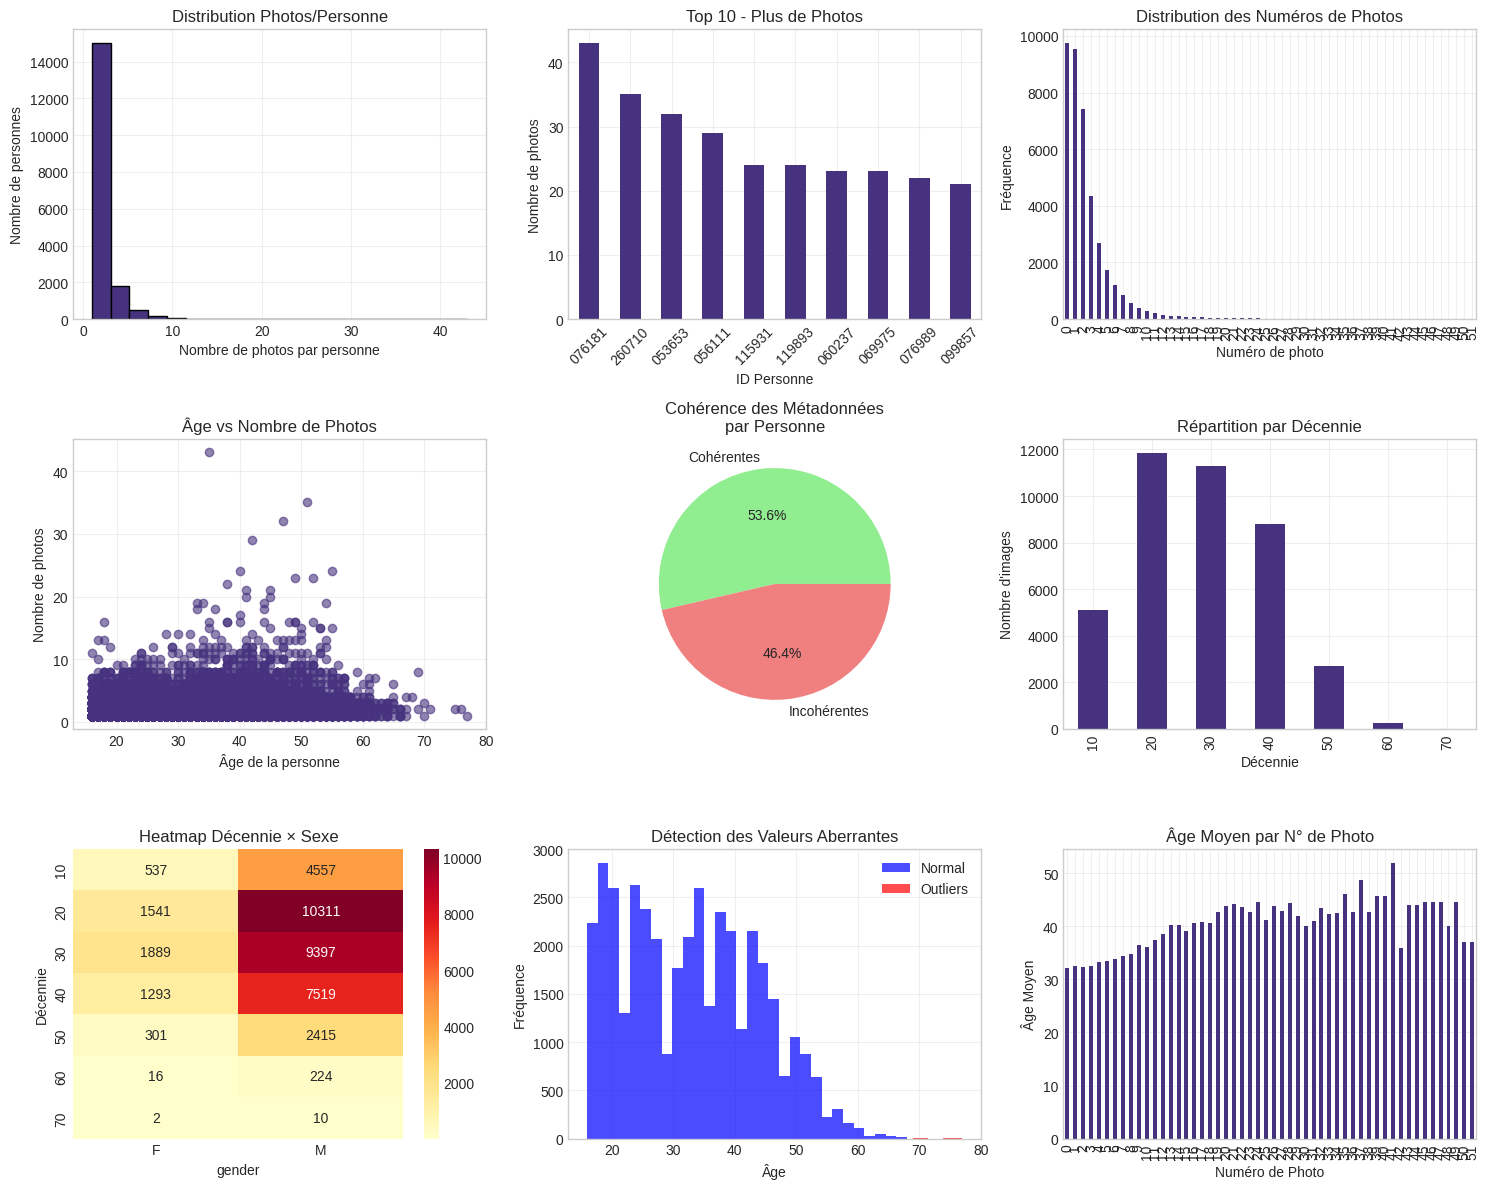


📋 RAPPORT D'ANALYSE DÉTAILLÉ:
   Photos par personne - Min: 1, Max: 43
   Personnes avec 1 seule photo: 6898
   Personnes avec 2+ photos: 10690
   Cohérence des métadonnées: 9430/17588 personnes (53.6%)
   ⚠️  8158 personnes avec métadonnées incohérentes détectées!
   Valeurs aberrantes détectées: 19 images (0.05%)
   Âges aberrants: 69-77 ans

📸 Distribution des numéros de photos:
   Photo 0: 9,746 images (24.4%)
   Photo 1: 9,542 images (23.8%)
   Photo 2: 7,437 images (18.6%)
   Photo 3: 4,346 images (10.9%)
   Photo 4: 2,702 images (6.8%)
   Photo 5: 1,726 images (4.3%)
   Photo 6: 1,217 images (3.0%)
   Photo 7: 838 images (2.1%)
   Photo 8: 574 images (1.4%)
   Photo 9: 403 images (1.0%)
   Photo 10: 295 images (0.7%)
   Photo 11: 230 images (0.6%)
   Photo 12: 158 images (0.4%)
   Photo 13: 122 images (0.3%)
   Photo 14: 99 images (0.2%)
   Photo 15: 84 images (0.2%)
   Photo 16: 73 images (0.2%)
   Photo 17: 60 images (0.1%)
   Photo 18: 40 images (0.1%)
   Photo 19: 43 images

In [8]:
if len(df_train) > 0:
    # Analyse avancée des patterns dans les données
    print("🔍 ANALYSE AVANCÉE DES PATTERNS")
    print("="*35)

    # Analyse des ID de personnes
    unique_persons = df_train['person_id'].nunique()
    total_images = len(df_train)
    avg_photos_per_person = total_images / unique_persons

    print(f"Statistiques générales:")
    print(f"   Personnes uniques: {unique_persons:,}")
    print(f"   Total d'images: {total_images:,}")
    print(f"   Photos par personne (moyenne): {avg_photos_per_person:.1f}")

    # Distribution des photos par personne
    photos_distribution = df_train['person_id'].value_counts()

    plt.figure(figsize=(15, 12))

    # Distribution du nombre de photos par personne
    plt.subplot(3, 3, 1)
    photos_distribution.hist(bins=20, edgecolor='black')
    plt.xlabel('Nombre de photos par personne')
    plt.ylabel('Nombre de personnes')
    plt.title('Distribution Photos/Personne')
    plt.grid(True, alpha=0.3)

    # Top 10 des personnes avec le plus de photos
    plt.subplot(3, 3, 2)
    top_10_persons = photos_distribution.head(10)
    top_10_persons.plot(kind='bar')
    plt.xlabel('ID Personne')
    plt.ylabel('Nombre de photos')
    plt.title('Top 10 - Plus de Photos')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Distribution des numéros de photos
    plt.subplot(3, 3, 3)
    photo_nums = df_train['photo_num'].value_counts().sort_index()
    photo_nums.plot(kind='bar')
    plt.xlabel('Numéro de photo')
    plt.ylabel('Fréquence')
    plt.title('Distribution des Numéros de Photos')
    plt.grid(True, alpha=0.3)

    # Corrélation âge vs nombre de photos par personne
    plt.subplot(3, 3, 4)
    person_stats = df_train.groupby('person_id').agg({
        'age': 'first',  # l'âge est le même pour toutes les photos d'une personne
        'photo_num': 'count'  # nombre de photos par personne
    }).rename(columns={'photo_num': 'num_photos'})

    plt.scatter(person_stats['age'], person_stats['num_photos'], alpha=0.6)
    plt.xlabel('Âge de la personne')
    plt.ylabel('Nombre de photos')
    plt.title('Âge vs Nombre de Photos')
    plt.grid(True, alpha=0.3)

    # Analyse de la cohérence des métadonnées par personne
    plt.subplot(3, 3, 5)
    # Vérifier si une même personne a des métadonnées cohérentes
    inconsistencies = 0
    consistent_persons = 0

    for person_id in df_train['person_id'].unique():
        person_data = df_train[df_train['person_id'] == person_id]
        unique_ages = person_data['age'].nunique()
        unique_genders = person_data['gender'].nunique()

        if unique_ages > 1 or unique_genders > 1:
            inconsistencies += 1
        else:
            consistent_persons += 1

    consistency_data = [consistent_persons, inconsistencies]
    consistency_labels = ['Cohérentes', 'Incohérentes']
    colors = ['lightgreen', 'lightcoral']

    plt.pie(consistency_data, labels=consistency_labels, autopct='%1.1f%%', colors=colors)
    plt.title('Cohérence des Métadonnées\npar Personne')

    # Distribution des âges par décennie
    plt.subplot(3, 3, 6)
    df_train['decade'] = (df_train['age'] // 10) * 10
    decade_counts = df_train['decade'].value_counts().sort_index()
    decade_counts.plot(kind='bar')
    plt.xlabel('Décennie')
    plt.ylabel('Nombre d\'images')
    plt.title('Répartition par Décennie')
    plt.grid(True, alpha=0.3)

    # Heatmap de la distribution âge x sexe (plus détaillée)
    plt.subplot(3, 3, 7)
    age_gender_crosstab = pd.crosstab(df_train['decade'], df_train['gender'])
    sns.heatmap(age_gender_crosstab, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Heatmap Décennie × Sexe')
    plt.ylabel('Décennie')

    # Analyse des valeurs aberrantes dans les âges
    plt.subplot(3, 3, 8)
    Q1 = df_train['age'].quantile(0.25)
    Q3 = df_train['age'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_train[(df_train['age'] < lower_bound) | (df_train['age'] > upper_bound)]
    normal_ages = df_train[(df_train['age'] >= lower_bound) & (df_train['age'] <= upper_bound)]

    plt.hist(normal_ages['age'], bins=30, alpha=0.7, label='Normal', color='blue')
    if len(outliers) > 0:
        plt.hist(outliers['age'], bins=10, alpha=0.7, label='Outliers', color='red')
    plt.xlabel('Âge')
    plt.ylabel('Fréquence')
    plt.title('Détection des Valeurs Aberrantes')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Summary statistics par photo num
    plt.subplot(3, 3, 9)
    photo_num_stats = df_train.groupby('photo_num')['age'].mean()
    photo_num_stats.plot(kind='bar')
    plt.xlabel('Numéro de Photo')
    plt.ylabel('Âge Moyen')
    plt.title('Âge Moyen par N° de Photo')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Rapport détaillé
    print(f"\n📋 RAPPORT D'ANALYSE DÉTAILLÉ:")
    print(f"   Photos par personne - Min: {photos_distribution.min()}, Max: {photos_distribution.max()}")
    print(f"   Personnes avec 1 seule photo: {(photos_distribution == 1).sum()}")
    print(f"   Personnes avec 2+ photos: {(photos_distribution > 1).sum()}")
    print(f"   Cohérence des métadonnées: {consistent_persons}/{unique_persons} personnes ({consistent_persons/unique_persons*100:.1f}%)")

    if inconsistencies > 0:
        print(f"   ⚠️  {inconsistencies} personnes avec métadonnées incohérentes détectées!")

    print(f"   Valeurs aberrantes détectées: {len(outliers)} images ({len(outliers)/len(df_train)*100:.2f}%)")
    if len(outliers) > 0:
        print(f"   Âges aberrants: {outliers['age'].min()}-{outliers['age'].max()} ans")

    # Analyse des numéros de photos
    print(f"\n📸 Distribution des numéros de photos:")
    for photo_num in sorted(df_train['photo_num'].unique()):
        count = (df_train['photo_num'] == photo_num).sum()
        percentage = count / len(df_train) * 100
        print(f"   Photo {photo_num}: {count:,} images ({percentage:.1f}%)")

else:
    print("⚠️  Pas de données à analyser - dataset non disponible")

## 3. Préparation des Données pour l'Entraînement

Maintenant que nous avons une compréhension approfondie de nos données, préparons-les pour l'entraînement du modèle.

### 3.1 Train/Validation Split Stratifié

Nous allons créer une séparation intelligente en tenant compte des déséquilibres identifiés.

In [9]:
# Division des données par tranches d'âge pour la stratification
if len(df_train) > 0:
    print("🎯 PRÉPARATION DE LA STRATIFICATION")
    print("="*40)

    # Créer des tranches d'âge pour une meilleure stratification
    age_bins = [0, 25, 35, 45, 55, 65, 100]
    age_labels = ['0-24', '25-34', '35-44', '45-54', '55-64', '65+']
    df_train['age_group'] = pd.cut(df_train['age'], bins=age_bins, labels=age_labels, right=False)

    print("📊 Distribution par tranches d'âge:")
    print(df_train['age_group'].value_counts().sort_index())

    # Créer une stratification combinée âge + sexe
    df_train['stratify_group'] = df_train['age_group'].astype(str) + '_' + df_train['gender']
    print("\n📊 Distribution par groupes âge+sexe:")
    print(df_train['stratify_group'].value_counts().sort_index())
else:
    print("⚠️  Pas de données à analyser - dataset non disponible")

🎯 PRÉPARATION DE LA STRATIFICATION
📊 Distribution par tranches d'âge:
age_group
0-24     11616
25-34    10416
35-44    11478
45-54     5557
55-64      886
65+         59
Name: count, dtype: int64

📊 Distribution par groupes âge+sexe:
stratify_group
0-24_F      1299
0-24_M     10317
25-34_F     1597
25-34_M     8819
35-44_F     1907
35-44_M     9571
45-54_F      668
45-54_M     4889
55-64_F      104
55-64_M      782
65+_F          4
65+_M         55
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split

🔄 CRÉATION DU SPLIT TRAIN/VALIDATION STRATIFIÉ
✅ Split terminé:
   Train: 32009 images (80.0%)
   Validation: 8003 images (20.0%)

📊 Distribution par sexe:
   Train - Hommes: 86.1%, Femmes: 13.9%
   Val   - Hommes: 86.1%, Femmes: 13.9%

📊 Statistiques des âges:
   Train - Âge moyen: 32.9 ans (std: 10.9)
   Val   - Âge moyen: 32.8 ans (std: 10.9)


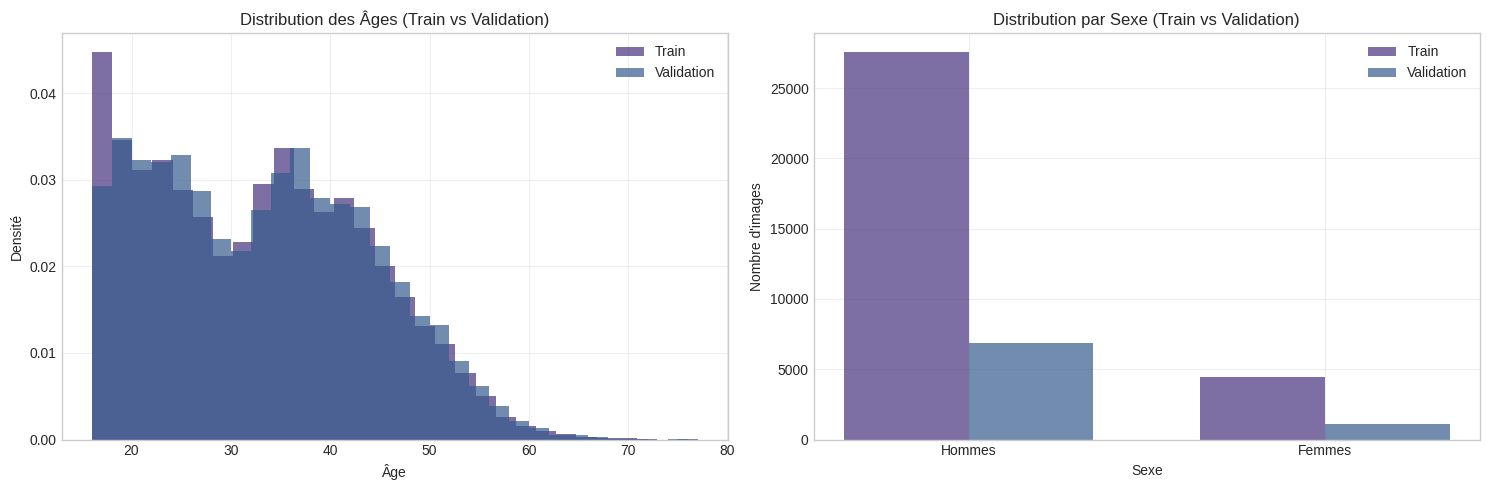


🎯 Données prêtes pour l'entraînement du modèle!


In [11]:
if len(df_train) > 0:
    # Split stratifié train/validation
    print("🔄 CRÉATION DU SPLIT TRAIN/VALIDATION STRATIFIÉ")
    print("="*50)

    # On utilise la stratification combinée pour s'assurer que chaque groupe âge+sexe
    # est représenté proportionnellement dans train et validation
    X = df_train[['file_path', 'person_id', 'photo_num', 'gender']].copy()
    y = df_train['age'].copy()
    stratify_labels = df_train['stratify_group']

    # Split 80/20 avec stratification
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=stratify_labels
    )

    print(f"✅ Split terminé:")
    print(f"   Train: {len(X_train)} images ({len(X_train)/len(df_train)*100:.1f}%)")
    print(f"   Validation: {len(X_val)} images ({len(X_val)/len(df_train)*100:.1f}%)")

    # Vérification de la distribution par sexe dans chaque ensemble
    train_gender_dist = X_train['gender'].value_counts(normalize=True)
    val_gender_dist = X_val['gender'].value_counts(normalize=True)

    print(f"\n📊 Distribution par sexe:")
    print(f"   Train - Hommes: {train_gender_dist['M']:.1%}, Femmes: {train_gender_dist['F']:.1%}")
    print(f"   Val   - Hommes: {val_gender_dist['M']:.1%}, Femmes: {val_gender_dist['F']:.1%}")

    # Vérification de la distribution des âges
    print(f"\n📊 Statistiques des âges:")
    print(f"   Train - Âge moyen: {y_train.mean():.1f} ans (std: {y_train.std():.1f})")
    print(f"   Val   - Âge moyen: {y_val.mean():.1f} ans (std: {y_val.std():.1f})")

    # Visualisation de la distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Distribution des âges
    axes[0].hist(y_train, bins=30, alpha=0.7, label='Train', density=True)
    axes[0].hist(y_val, bins=30, alpha=0.7, label='Validation', density=True)
    axes[0].set_xlabel('Âge')
    axes[0].set_ylabel('Densité')
    axes[0].set_title('Distribution des Âges (Train vs Validation)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Distribution par sexe
    train_gender_counts = X_train['gender'].value_counts()
    val_gender_counts = X_val['gender'].value_counts()

    x = np.arange(len(train_gender_counts))
    width = 0.35

    axes[1].bar(x - width/2, train_gender_counts.values, width, label='Train', alpha=0.7)
    axes[1].bar(x + width/2, val_gender_counts.values, width, label='Validation', alpha=0.7)
    axes[1].set_xlabel('Sexe')
    axes[1].set_ylabel('Nombre d\'images')
    axes[1].set_title('Distribution par Sexe (Train vs Validation)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(['Hommes', 'Femmes'])
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n🎯 Données prêtes pour l'entraînement du modèle!")

else:
    print("⚠️  Pas de données disponibles pour le split - dataset non chargé")

### 3.2 Dataset et DataLoader PyTorch

Créons les classes nécessaires pour charger et transformer nos images de manière efficace.

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import torch.optim as optim

# Définir le device (ajustez si nécessaire)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("biblio pytorch importé avec succès")

biblio pytorch importé avec succès


In [13]:
from torch.utils.data import Dataset, DataLoader

In [14]:
if len(df_train) > 0:
    print("🤖 DÉFINITION DU MODÈLE D'ESTIMATION D'ÂGE")
    print("="*45)

    class AgeDataset(Dataset):
        def __init__(self, dataframe, transform=None):
            """
            Dataset pour l'estimation d'âge
            """
            self.dataframe = dataframe.reset_index(drop=True)
            self.transform = transform

        def __len__(self):
            return len(self.dataframe)

        def __getitem__(self, idx):
            # Récupérer le chemin de l'image et l'âge
            img_path = self.dataframe.iloc[idx]['file_path']
            age = self.dataframe.iloc[idx]['age']

            # Charger l'image
            image = Image.open(img_path).convert('RGB')

            # Appliquer les transformations
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(age, dtype=torch.float32)

    class AgeEstimationModel(nn.Module):
        def __init__(self, pretrained=True):
            """
            Modèle d'estimation d'âge basé sur ResNet50
            """
            super(AgeEstimationModel, self).__init__()

            # Utiliser ResNet50 pré-entraîné
            self.backbone = models.resnet50(pretrained=pretrained)

            # Remplacer la dernière couche pour la régression d'âge
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, 1)  # Sortie unique pour l'âge
            )

        def forward(self, x):
            return self.backbone(x)

    # Définir les transformations pour l'entraînement et la validation
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Créer les datasets
    print("Création des datasets...")
    train_dataset = AgeDataset(
        pd.concat([X_train, y_train], axis=1),
        transform=train_transform
    )
    val_dataset = AgeDataset(
        pd.concat([X_val, y_val], axis=1),
        transform=val_transform
    )

    # Créer les DataLoaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"✅ Datasets créés:")
    print(f"   Train: {len(train_dataset)} images")
    print(f"   Validation: {len(val_dataset)} images")
    print(f"   Batch size: {batch_size}")

    # Initialiser le modèle
    print("\n🧠 Initialisation du modèle...")
    model = AgeEstimationModel(pretrained=True)
    model = model.to(device)

    # Définir la fonction de perte et l'optimiseur
    criterion = nn.MSELoss()  # Mean Squared Error pour la régression
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    print(f"✅ Modèle configuré:")
    print(f"   Architecture: ResNet50")
    print(f"   Critère: MSE Loss")
    print(f"   Optimiseur: Adam (lr=0.001)")
    print(f"   Device: {device}")

    # Compter les paramètres
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nParamètres du modèle:")
    print(f"   Total: {total_params:,}")
    print(f"   Entraînables: {trainable_params:,}")

    print(f"\n Modèle prêt pour l'entraînement!")

else:
    print("Impossible de créer le modèle - dataset non disponible")

🤖 DÉFINITION DU MODÈLE D'ESTIMATION D'ÂGE
Création des datasets...
✅ Datasets créés:
   Train: 32009 images
   Validation: 8003 images
   Batch size: 32

🧠 Initialisation du modèle...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


✅ Modèle configuré:
   Architecture: ResNet50
   Critère: MSE Loss
   Optimiseur: Adam (lr=0.001)
   Device: cuda

Paramètres du modèle:
   Total: 24,622,913
   Entraînables: 24,622,913

 Modèle prêt pour l'entraînement!


In [15]:
from tqdm import tqdm
import numpy as np
import os
import torch.nn.functional as F

# --- Hyperparamètres d'entraînement ---
NUM_EPOCHS = 30
BEST_MODEL_PATH = 'best_age_estimation_model.pth'

# Stocker les métriques
history = {
    'train_loss': [],
    'val_loss': [],
    'val_mae': []
}
best_val_mae = float('inf')

print("🚀 Démarrage de l'entraînement...")
print("="*30)

# --- Fonction d'entraînement d'une époque ---
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    # tqdm pour afficher la barre de progression
    for images, ages in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        # S'assurer que les âges sont des float32 et ont la bonne forme (batch_size, 1)
        ages = ages.view(-1, 1).to(device) 

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, ages)
        
        # Backward pass et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# --- Fonction de validation ---
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, ages in tqdm(dataloader, desc="Validation"):
            images = images.to(device)
            # S'assurer que les âges sont des float32 et ont la bonne forme (batch_size, 1)
            ages = ages.view(-1, 1).to(device)
            
            outputs = model(images)
            loss = criterion(outputs, ages)
            
            running_loss += loss.item() * images.size(0)
            
            # Stocker les prédictions et les cibles pour calculer la MAE
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_targets.extend(ages.cpu().numpy().flatten())

    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Calculer la Mean Absolute Error (MAE)
    mae = np.mean(np.abs(np.array(all_preds) - np.array(all_targets)))
    
    return epoch_loss, mae

# --- Boucle Principale d'Entraînement ---
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n--- ÉPOQUE {epoch}/{NUM_EPOCHS} ---")
    
    # Phase d'entraînement
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Phase de validation
    val_loss, val_mae = validate(model, val_loader, criterion, device)
    
    # Mettre à jour le scheduler
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_mae) # Utiliser la MAE de validation pour la réduction du LR
    new_lr = optimizer.param_groups[0]['lr']

    # Afficher les métriques
    print(f"Train Loss (MSE): {train_loss:.4f}")
    print(f"Validation Loss (MSE): {val_loss:.4f}")
    print(f"Validation MAE: {val_mae:.4f} années")
    print(f"LR: {current_lr:.6f} -> {new_lr:.6f}")
    
    # Enregistrer le meilleur modèle
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        # Créer le répertoire si il n'existe pas
        os.makedirs(os.path.dirname(BEST_MODEL_PATH) or '.', exist_ok=True)
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"✅ Modèle sauvegardé ! Nouvelle meilleure MAE: {best_val_mae:.4f}")

    # Stocker l'historique
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)

print("\n✨ Entraînement terminé !")
print(f"Meilleur modèle sauvegardé à: {BEST_MODEL_PATH} (MAE: {best_val_mae:.4f})")

🚀 Démarrage de l'entraînement...

--- ÉPOQUE 1/30 ---


Validation: 100%|██████████| 251/251 [00:24<00:00, 10.10it/s]


Train Loss (MSE): 46.9120
Validation Loss (MSE): 37.5547
Validation MAE: 4.7783 années
LR: 0.001000 -> 0.001000
✅ Modèle sauvegardé ! Nouvelle meilleure MAE: 4.7783

--- ÉPOQUE 2/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.47it/s]


Train Loss (MSE): 32.5104
Validation Loss (MSE): 62.4660
Validation MAE: 6.6694 années
LR: 0.001000 -> 0.001000

--- ÉPOQUE 3/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.15it/s]


Train Loss (MSE): 29.1237
Validation Loss (MSE): 20.2575
Validation MAE: 3.4509 années
LR: 0.001000 -> 0.001000
✅ Modèle sauvegardé ! Nouvelle meilleure MAE: 3.4509

--- ÉPOQUE 4/30 ---


Validation: 100%|██████████| 251/251 [00:18<00:00, 13.78it/s]


Train Loss (MSE): 27.5317
Validation Loss (MSE): 18.3133
Validation MAE: 3.3164 années
LR: 0.001000 -> 0.001000
✅ Modèle sauvegardé ! Nouvelle meilleure MAE: 3.3164

--- ÉPOQUE 5/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.13it/s]


Train Loss (MSE): 26.0689
Validation Loss (MSE): 19.8626
Validation MAE: 3.4466 années
LR: 0.001000 -> 0.001000

--- ÉPOQUE 6/30 ---


Validation: 100%|██████████| 251/251 [00:17<00:00, 14.76it/s]


Train Loss (MSE): 24.3748
Validation Loss (MSE): 17.4703
Validation MAE: 3.2270 années
LR: 0.001000 -> 0.001000
✅ Modèle sauvegardé ! Nouvelle meilleure MAE: 3.2270

--- ÉPOQUE 7/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.09it/s]


Train Loss (MSE): 24.0881
Validation Loss (MSE): 18.9604
Validation MAE: 3.3164 années
LR: 0.001000 -> 0.001000

--- ÉPOQUE 8/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.39it/s]


Train Loss (MSE): 22.5029
Validation Loss (MSE): 21.8038
Validation MAE: 3.5733 années
LR: 0.001000 -> 0.001000

--- ÉPOQUE 9/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.05it/s]


Train Loss (MSE): 21.4397
Validation Loss (MSE): 15.7616
Validation MAE: 3.0480 années
LR: 0.001000 -> 0.001000
✅ Modèle sauvegardé ! Nouvelle meilleure MAE: 3.0480

--- ÉPOQUE 10/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.01it/s]


Train Loss (MSE): 20.4425
Validation Loss (MSE): 16.2922
Validation MAE: 3.1397 années
LR: 0.001000 -> 0.001000

--- ÉPOQUE 11/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 14.93it/s]


Train Loss (MSE): 19.4487
Validation Loss (MSE): 16.5415
Validation MAE: 3.1034 années
LR: 0.001000 -> 0.001000

--- ÉPOQUE 12/30 ---


Validation: 100%|██████████| 251/251 [00:17<00:00, 14.43it/s]


Train Loss (MSE): 19.3115
Validation Loss (MSE): 23.5691
Validation MAE: 3.8797 années
LR: 0.001000 -> 0.001000

--- ÉPOQUE 13/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.10it/s]


Train Loss (MSE): 19.0404
Validation Loss (MSE): 17.2097
Validation MAE: 3.1778 années
LR: 0.001000 -> 0.000500

--- ÉPOQUE 14/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.56it/s]


Train Loss (MSE): 15.8032
Validation Loss (MSE): 15.6451
Validation MAE: 3.1083 années
LR: 0.000500 -> 0.000500

--- ÉPOQUE 15/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.51it/s]


Train Loss (MSE): 15.0889
Validation Loss (MSE): 13.2962
Validation MAE: 2.8053 années
LR: 0.000500 -> 0.000500
✅ Modèle sauvegardé ! Nouvelle meilleure MAE: 2.8053

--- ÉPOQUE 16/30 ---


Validation: 100%|██████████| 251/251 [00:17<00:00, 14.64it/s]


Train Loss (MSE): 14.7077
Validation Loss (MSE): 13.4390
Validation MAE: 2.8130 années
LR: 0.000500 -> 0.000500

--- ÉPOQUE 17/30 ---


Validation: 100%|██████████| 251/251 [00:17<00:00, 14.28it/s]


Train Loss (MSE): 14.0179
Validation Loss (MSE): 15.4184
Validation MAE: 2.9878 années
LR: 0.000500 -> 0.000500

--- ÉPOQUE 18/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.63it/s]


Train Loss (MSE): 13.8043
Validation Loss (MSE): 12.8572
Validation MAE: 2.7411 années
LR: 0.000500 -> 0.000500
✅ Modèle sauvegardé ! Nouvelle meilleure MAE: 2.7411

--- ÉPOQUE 19/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.58it/s]


Train Loss (MSE): 13.5975
Validation Loss (MSE): 12.7834
Validation MAE: 2.7356 années
LR: 0.000500 -> 0.000500
✅ Modèle sauvegardé ! Nouvelle meilleure MAE: 2.7356

--- ÉPOQUE 20/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.66it/s]


Train Loss (MSE): 13.1923
Validation Loss (MSE): 13.2863
Validation MAE: 2.7748 années
LR: 0.000500 -> 0.000500

--- ÉPOQUE 21/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.54it/s]


Train Loss (MSE): 13.2902
Validation Loss (MSE): 15.2220
Validation MAE: 2.9728 années
LR: 0.000500 -> 0.000500

--- ÉPOQUE 22/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.39it/s]


Train Loss (MSE): 12.6286
Validation Loss (MSE): 12.5939
Validation MAE: 2.7133 années
LR: 0.000500 -> 0.000500
✅ Modèle sauvegardé ! Nouvelle meilleure MAE: 2.7133

--- ÉPOQUE 23/30 ---


Validation: 100%|██████████| 251/251 [00:18<00:00, 13.76it/s]


Train Loss (MSE): 12.3469
Validation Loss (MSE): 15.1363
Validation MAE: 3.0276 années
LR: 0.000500 -> 0.000500

--- ÉPOQUE 24/30 ---


Validation: 100%|██████████| 251/251 [00:18<00:00, 13.43it/s]


Train Loss (MSE): 12.2079
Validation Loss (MSE): 13.0620
Validation MAE: 2.7550 années
LR: 0.000500 -> 0.000500

--- ÉPOQUE 25/30 ---


Validation: 100%|██████████| 251/251 [00:17<00:00, 14.24it/s]


Train Loss (MSE): 11.9188
Validation Loss (MSE): 15.3734
Validation MAE: 3.0743 années
LR: 0.000500 -> 0.000500

--- ÉPOQUE 26/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.00it/s]


Train Loss (MSE): 11.9164
Validation Loss (MSE): 13.1311
Validation MAE: 2.8061 années
LR: 0.000500 -> 0.000250

--- ÉPOQUE 27/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.28it/s]


Train Loss (MSE): 10.1962
Validation Loss (MSE): 11.9046
Validation MAE: 2.6159 années
LR: 0.000250 -> 0.000250
✅ Modèle sauvegardé ! Nouvelle meilleure MAE: 2.6159

--- ÉPOQUE 28/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.36it/s]


Train Loss (MSE): 9.9183
Validation Loss (MSE): 12.2410
Validation MAE: 2.6625 années
LR: 0.000250 -> 0.000250

--- ÉPOQUE 29/30 ---


Validation: 100%|██████████| 251/251 [00:16<00:00, 15.45it/s]


Train Loss (MSE): 9.7354
Validation Loss (MSE): 13.0188
Validation MAE: 2.7284 années
LR: 0.000250 -> 0.000250

--- ÉPOQUE 30/30 ---


Validation: 100%|██████████| 251/251 [00:17<00:00, 13.97it/s]


Train Loss (MSE): 9.4788
Validation Loss (MSE): 11.8652
Validation MAE: 2.6100 années
LR: 0.000250 -> 0.000250
✅ Modèle sauvegardé ! Nouvelle meilleure MAE: 2.6100

✨ Entraînement terminé !
Meilleur modèle sauvegardé à: best_age_estimation_model.pth (MAE: 2.6100)


In [16]:
# Cellule à ajouter après la fonction train_one_epoch

def validate_one_epoch(model, dataloader, criterion, device):
    """
    Fonction de validation d'une époque.
    Calcule la perte et la Mean Absolute Error (MAE) sur le jeu de validation.
    """
    model.eval()  # Passer le modèle en mode évaluation (très important !)
    running_loss = 0.0
    total_mae = 0.0

    with torch.no_grad():  # Pas besoin de calculer les gradients en validation
        for images, ages in tqdm(dataloader, desc="Validating"):
            images = images.to(device)
            # S'assurer que les âges sont des float32 et ont la bonne forme
            ages = ages.view(-1, 1).to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, ages)

            # Mettre à jour les métriques
            running_loss += loss.item() * images.size(0)
            
            # Calculer la MAE (Mean Absolute Error)
            mae = torch.abs(outputs - ages).sum()
            total_mae += mae.item()

    # Calculer les moyennes pour l'époque entière
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_mae = total_mae / len(dataloader.dataset)
    
    return epoch_loss, epoch_mae

In [17]:
# Cellule à ajouter après la fonction de validation

# Démarrage de l'entraînement
for epoch in range(NUM_EPOCHS):
    print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    
    # --- Phase d'entraînement ---
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    
    # --- Phase de validation ---
    val_loss, val_mae = validate_one_epoch(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)
    
    # Afficher les résultats de l'époque
    print(f"Epoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.2f} ans")
    
    # Mise à jour du scheduler (pour réduire le learning rate si besoin)
    scheduler.step(val_mae)
    
    # Sauvegarder le meilleur modèle basé sur la MAE de validation
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"✨ New best model saved! Validation MAE: {best_val_mae:.2f} ans")

print("\n🎉 Entraînement terminé !")
print(f"Meilleure MAE obtenue en validation: {best_val_mae:.2f} ans")

--- Epoch 1/30 ---


Validating: 100%|██████████| 251/251 [00:16<00:00, 15.01it/s]


Epoch 1 Summary:
  Train Loss: 9.2584
  Val Loss: 12.2355 | Val MAE: 2.71 ans
--- Epoch 2/30 ---


Validating: 100%|██████████| 251/251 [00:16<00:00, 15.09it/s]


Epoch 2 Summary:
  Train Loss: 8.9237
  Val Loss: 12.7079 | Val MAE: 2.71 ans
--- Epoch 3/30 ---


Validating: 100%|██████████| 251/251 [00:16<00:00, 15.15it/s]


Epoch 3 Summary:
  Train Loss: 8.7922
  Val Loss: 11.5738 | Val MAE: 2.59 ans
✨ New best model saved! Validation MAE: 2.59 ans
--- Epoch 4/30 ---


Validating: 100%|██████████| 251/251 [00:17<00:00, 14.38it/s]


Epoch 4 Summary:
  Train Loss: 8.5383
  Val Loss: 12.1040 | Val MAE: 2.68 ans
--- Epoch 5/30 ---


Validating: 100%|██████████| 251/251 [00:16<00:00, 15.21it/s]


Epoch 5 Summary:
  Train Loss: 8.3519
  Val Loss: 11.9744 | Val MAE: 2.63 ans
--- Epoch 6/30 ---


Validating: 100%|██████████| 251/251 [00:19<00:00, 13.20it/s]


Epoch 6 Summary:
  Train Loss: 8.2572
  Val Loss: 11.8400 | Val MAE: 2.61 ans
--- Epoch 7/30 ---


Validating: 100%|██████████| 251/251 [00:16<00:00, 15.27it/s]


Epoch 7 Summary:
  Train Loss: 8.1417
  Val Loss: 11.8789 | Val MAE: 2.61 ans
--- Epoch 8/30 ---


Validating: 100%|██████████| 251/251 [00:16<00:00, 15.20it/s]


Epoch 8 Summary:
  Train Loss: 7.4829
  Val Loss: 11.5670 | Val MAE: 2.58 ans
✨ New best model saved! Validation MAE: 2.58 ans
--- Epoch 9/30 ---


Validating: 100%|██████████| 251/251 [00:18<00:00, 13.35it/s]


Epoch 9 Summary:
  Train Loss: 7.1356
  Val Loss: 11.4883 | Val MAE: 2.58 ans
--- Epoch 10/30 ---


Validating: 100%|██████████| 251/251 [00:18<00:00, 13.25it/s]


Epoch 10 Summary:
  Train Loss: 6.9878
  Val Loss: 11.3573 | Val MAE: 2.55 ans
✨ New best model saved! Validation MAE: 2.55 ans
--- Epoch 11/30 ---


Validating: 100%|██████████| 251/251 [00:16<00:00, 15.09it/s]


Epoch 11 Summary:
  Train Loss: 6.8485
  Val Loss: 11.5294 | Val MAE: 2.58 ans
--- Epoch 12/30 ---


Validating: 100%|██████████| 251/251 [00:16<00:00, 15.07it/s]


Epoch 12 Summary:
  Train Loss: 6.6815
  Val Loss: 11.3577 | Val MAE: 2.56 ans
--- Epoch 13/30 ---


Validating: 100%|██████████| 251/251 [00:17<00:00, 14.66it/s]


Epoch 13 Summary:
  Train Loss: 6.5920
  Val Loss: 12.3233 | Val MAE: 2.65 ans
--- Epoch 14/30 ---


Validating: 100%|██████████| 251/251 [00:16<00:00, 14.96it/s]


Epoch 14 Summary:
  Train Loss: 6.4976
  Val Loss: 11.5454 | Val MAE: 2.58 ans
--- Epoch 15/30 ---


Validating: 100%|██████████| 251/251 [00:17<00:00, 14.54it/s]


Epoch 15 Summary:
  Train Loss: 6.0941
  Val Loss: 11.2287 | Val MAE: 2.55 ans
--- Epoch 16/30 ---


Validating: 100%|██████████| 251/251 [00:17<00:00, 14.61it/s]


Epoch 16 Summary:
  Train Loss: 5.9189
  Val Loss: 11.4323 | Val MAE: 2.56 ans
--- Epoch 17/30 ---


Validating: 100%|██████████| 251/251 [00:17<00:00, 14.36it/s]


Epoch 17 Summary:
  Train Loss: 5.8824
  Val Loss: 11.2935 | Val MAE: 2.54 ans
✨ New best model saved! Validation MAE: 2.54 ans
--- Epoch 18/30 ---


Validating: 100%|██████████| 251/251 [00:17<00:00, 14.29it/s]


Epoch 18 Summary:
  Train Loss: 5.8214
  Val Loss: 11.5328 | Val MAE: 2.57 ans
--- Epoch 19/30 ---


Validating: 100%|██████████| 251/251 [00:17<00:00, 14.13it/s]


Epoch 19 Summary:
  Train Loss: 5.7745
  Val Loss: 11.4920 | Val MAE: 2.56 ans
--- Epoch 20/30 ---


Validating: 100%|██████████| 251/251 [00:17<00:00, 14.68it/s]


Epoch 20 Summary:
  Train Loss: 5.6045
  Val Loss: 11.4863 | Val MAE: 2.56 ans
--- Epoch 21/30 ---


Validating: 100%|██████████| 251/251 [00:17<00:00, 14.50it/s]


Epoch 21 Summary:
  Train Loss: 5.5990
  Val Loss: 11.2323 | Val MAE: 2.54 ans
✨ New best model saved! Validation MAE: 2.54 ans
--- Epoch 22/30 ---


Validating: 100%|██████████| 251/251 [00:20<00:00, 12.40it/s]


Epoch 22 Summary:
  Train Loss: 5.5587
  Val Loss: 11.2407 | Val MAE: 2.54 ans
✨ New best model saved! Validation MAE: 2.54 ans
--- Epoch 23/30 ---


Validating: 100%|██████████| 251/251 [00:18<00:00, 13.68it/s]


Epoch 23 Summary:
  Train Loss: 5.4902
  Val Loss: 11.3276 | Val MAE: 2.54 ans
--- Epoch 24/30 ---


Validating: 100%|██████████| 251/251 [00:18<00:00, 13.91it/s]


Epoch 24 Summary:
  Train Loss: 5.4185
  Val Loss: 11.6084 | Val MAE: 2.57 ans
--- Epoch 25/30 ---


Validating: 100%|██████████| 251/251 [00:17<00:00, 14.11it/s]


Epoch 25 Summary:
  Train Loss: 5.3781
  Val Loss: 11.4093 | Val MAE: 2.56 ans
--- Epoch 26/30 ---


Validating: 100%|██████████| 251/251 [00:16<00:00, 14.79it/s]


Epoch 26 Summary:
  Train Loss: 5.2751
  Val Loss: 11.8089 | Val MAE: 2.60 ans
--- Epoch 27/30 ---


Validating: 100%|██████████| 251/251 [00:16<00:00, 15.57it/s]


Epoch 27 Summary:
  Train Loss: 5.0892
  Val Loss: 11.3604 | Val MAE: 2.55 ans
--- Epoch 28/30 ---


Validating: 100%|██████████| 251/251 [00:17<00:00, 14.08it/s]


Epoch 28 Summary:
  Train Loss: 4.9589
  Val Loss: 11.3899 | Val MAE: 2.55 ans
--- Epoch 29/30 ---


Validating: 100%|██████████| 251/251 [00:16<00:00, 15.14it/s]


Epoch 29 Summary:
  Train Loss: 4.9247
  Val Loss: 11.2727 | Val MAE: 2.54 ans
--- Epoch 30/30 ---


Validating: 100%|██████████| 251/251 [00:16<00:00, 15.63it/s]

Epoch 30 Summary:
  Train Loss: 4.8889
  Val Loss: 11.3127 | Val MAE: 2.54 ans

🎉 Entraînement terminé !
Meilleure MAE obtenue en validation: 2.54 ans


In [18]:
# Cellule pour la prédiction finale

# (Optionnel mais recommandé) Créer un Dataset et un DataLoader pour le test
# Cela suppose que tu as une liste 'test_files' avec les chemins des images de test

class TestDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Utiliser les transformations de validation (sans data augmentation)
test_transform = val_transform 
test_dataset = TestDataset(test_files, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


# Fonction de prédiction
def predict_on_test(model, dataloader, model_path, device):
    # Charger les poids du meilleur modèle
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    all_predictions = []
    
    with torch.no_grad():
        for images in tqdm(dataloader, desc="Predicting on test set"):
            images = images.to(device)
            outputs = model(images)
            # .cpu() pour ramener sur le CPU, .numpy() pour convertir en array numpy
            predictions = outputs.cpu().numpy().flatten()
            all_predictions.extend(predictions)
            
    return np.array(all_predictions)

# Lancer la prédiction
print("\nLancement des prédictions sur le jeu de test...")
test_predictions = predict_on_test(model, test_loader, BEST_MODEL_PATH, device)

# Afficher quelques prédictions
print(f"\nPrédictions terminées. Total: {len(test_predictions)} images.")
print("Exemples de prédictions (âges) :")
print(test_predictions[:10].round(1))

# Créer le fichier de soumission (à adapter selon le format demandé par l'ANIP)
# Supposons qu'ils demandent un CSV avec 'filename' et 'age'
test_filenames = [Path(f).name for f in test_files]
submission_df = pd.DataFrame({
    'filename': test_filenames,
    'age': test_predictions
})

# Arrondir les âges à l'entier le plus proche
submission_df['age'] = submission_df['age'].round().astype(int)

submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"\nFichier de soumission créé : '{submission_path}'")
print(submission_df.head())


Lancement des prédictions sur le jeu de test...


Predicting on test set: 100%|██████████| 7/7 [00:01<00:00,  6.54it/s]


Prédictions terminées. Total: 200 images.
Exemples de prédictions (âges) :
[36.1 16.4 30.1 18.1 42.7 20.  36.4 43.6 37.  23.5]

Fichier de soumission créé : 'submission.csv'
  filename  age
0   45.JPG   36
1   56.JPG   16
2   89.JPG   30
3   20.JPG   18
4   58.JPG   43
